## Settings

In [1]:
source("/path/to/the/project/02_notebooks/00_setup.r")

In [2]:
p_load("ranger", "biotmle", "DESeq2", "dplyr", "BiocParallel", "SummarizedExperiment", "arm", "earth", "SuperLearner", "pheatmap", install = FALSE)

Warning message in p_load("ranger", "biotmle", "DESeq2", "dplyr", "BiocParallel", :
"Failed to install/load:
ranger, biotmle, arm, earth, SuperLearner"


## Updated functions

In [3]:
exp_biomarkertmle <- function(Y,
                              A,
                              W,
                              g_lib,
                              Q_lib,
                              cv_folds,
                              ...) {
  # check the case that Y is passed in as a column of a data.frame
  if (any(class(Y) == "data.frame")) Y <- as.numeric(unlist(Y[, 1]))
  if (any(class(A) == "data.frame")) A <- as.numeric(unlist(A[, 1]))
  assertthat::assert_that(length(unique(A)) > 1)

  # fit standard (possibly CV) TML estimator (n.b., guard = NULL)
  a_0 <- sort(unique(A[!is.na(A)]))
  suppressWarnings(
    tmle_fit <- drtmle::drtmle(
      Y = Y,
      A = A,
      W = W,
      a_0 = a_0,
      SL_g = g_lib,
      SL_Q = Q_lib,
      cvFolds = cv_folds,
      stratify = TRUE,
      guard = NULL,
      parallel = FALSE,
      use_future = FALSE,
      ...
    )
  )

  # compute ATE and estimated EIF by delta method
  ate_tmle <- tmle_fit$tmle$est[seq_along(a_0)[-1]] - tmle_fit$tmle$est[1]
  eif_tmle_delta <- tmle_fit$ic$ic[, seq_along(a_0)[-1]] - tmle_fit$ic$ic[, 1]

  # return only highest contrast (e.g., a[1] v a[5]) if many contrasts
  if (!is.vector(eif_tmle_delta)) {
    param_out <- ate_tmle[length(ate_tmle)]
    eif_out <- eif_tmle_delta[, ncol(eif_tmle_delta)] +
      ate_tmle[length(ate_tmle)]
  } else {
    param_out <- ate_tmle
    eif_out <- eif_tmle_delta + ate_tmle
  }
  assertthat::assert_that(is.vector(eif_out))

  # output
  out <- list(param = param_out, eif = eif_out)
  return(out)
}

In [4]:
biotmle_rnaseq <- function(se,
                          col_meta,
                          bppar_type = BiocParallel::MulticoreParam(),
                          cv_folds = 1,
                          g_lib = c(
                            "SL.mean", "SL.glm", "SL.bayesglm"
                          ),
                          Q_lib = c(
                            "SL.mean", "SL.bayesglm", "SL.earth", "SL.ranger"
                          ),
                          ...) {

  # catch input and invoke S4 class constructor for "bioTMLE" object
  print("Constuction of the bioTMLE object")
  call <- match.call(expand.dots = TRUE)
  biotmle <- .biotmle(
    SummarizedExperiment(
      assays = list(expMeasures = assay(se)),
      rowData = rowData(se),
      colData = colData(se)
    ),
    call = call,
    tmleOut = tibble::as_tibble(matrix(NA, 10, 10), .name_repair = "minimal"),
    topTable = tibble::as_tibble(matrix(NA, 10, 10), .name_repair = "minimal")
  )

  # invoke the voom transform from LIMMA if next-generation sequencing data)
  print("VOOM transformation")
    voom_out <- rnaseq_ic(biotmle)
    voom_exp <- 2^(voom_out$E)


  # set up parallelization based on input
  BiocParallel::bpprogressbar(bppar_type) <- TRUE
  BiocParallel::register(bppar_type, default = TRUE)

  # TMLE procedure to identify biomarkers based on an EXPOSURE

  Y <- tibble::as_tibble(t(voom_exp), .name_repair = "minimal")
  
  # simple sanity check of whether Y includes array values
  if (!all(apply(Y, 2, class) == "numeric")) {
  stop("Warning - values in Y do not appear to be numeric.")
  }

  # exposure / treatment
  A <- as.numeric(SummarizedExperiment::colData(se)[, col_meta])

  # baseline covariates
  W <- tibble::as_tibble(SummarizedExperiment::colData(se)[, -col_meta],
                     .name_repair = "minimal")
  W <- tibble::as_tibble(apply(W, 2, as.numeric), .name_repair = "minimal")


  # perform multi-level TMLE (of the ATE) for genes as Y
  print("Performing multi-level TMLE")
  biomarkertmle_out <- BiocParallel::bplapply(Y[, seq_along(Y)],
      exp_biomarkertmle,
      W = W,
      A = A,
      g_lib = c(
        "SL.mean", "SL.glm", "SL.bayesglm"),
      Q_lib = c(
        "SL.mean", "SL.bayesglm", "SL.earth", "SL.ranger"),
      cv_folds = 1,
      parallel = TRUE
    )
    print("Done; post-processing")
    biomarkertmle_params <- do.call(c, lapply(biomarkertmle_out, `[[`, "param"))
    biomarkertmle_eifs <- do.call(
    cbind.data.frame,
    lapply(biomarkertmle_out, `[[`, "eif")
    )

    biotmle@ateOut <- as.numeric(biomarkertmle_params)

    biomarker_eifs <- t(as.matrix(biomarkertmle_eifs))
    colnames(biomarker_eifs) <- colnames(se)
    biotmle@tmleOut <- tibble::as_tibble(
      biomarker_eifs,
      .name_repair = "minimal"
    )

    modtmle_out <- modtest_ic(biotmle = biotmle)
    print("Complete; returned object: modtmle_out")
    
    return(modtmle_out)
}

In [ ]:
colfunc <- colorRampPalette(c("#9f294c", "#e4f0ff", "#27678a"))
col_100 <- colfunc(100)
col_100 <- col_100[rev(1:length(col_100))]

In [5]:
produce_heatmap <- function(top_genes, se, dds){
    top_genes_idx = top_genes$ID
    top_genes_idx = as.numeric(as.character(top_genes_idx))
    mtx = assay(se)[top_genes_idx, ]
    annotation = as.data.frame(colData(dds)[, c("Group", "Batch")])
    ann_colors <- list(Group = c(Cneg = "#dc97b3", Cpos = "#da4370", `12WR1` = "#57b09c", `12WR2` = "#55dfa7"), Batch = c(CCL4 = "#063852", TAA = "#F0810F"))
    pheatmap(scale(mtx), col_100, cluster_rows = FALSE,
        show_rownames = TRUE, cluster_cols = FALSE, 
     #   gaps_row = c(10, 20, 30, 40),
        annotation_col = annotation,
        show_colnames = FALSE, clustering_method = "ward.D2",
        annotation_colors = ann_colors,
        cutree_rows = 7)
}

## Loading datasets

In [9]:
metadata <- read.csv("2022_08_12_CDL_regression_sample_annotation.csv", row.names = 1)

In [17]:
dds <- readRDS("03_outputs/03/dds_object_batch_group_wald.rds")

In [8]:
dds <- vst(dds)

## biotmle: cirrhosis

In [9]:
coldata_cir <- as.data.frame(dds@colData) %>%
  dplyr::select("Batch", "isCirrhotic")

In [10]:
se_cir <- SummarizedExperiment(assays = list(counts = assay(dds)), colData = coldata_cir)

In [11]:
#colData(dds)
cirrhotic_meta <- which(names(colData(se_cir)) %in% "isCirrhotic")

In [12]:
se_cir@colData$isCirrhotic[se_cir@colData$isCirrhotic == "no"] <- 0 
se_cir@colData$isCirrhotic[se_cir@colData$isCirrhotic == "yes"] <- 1 

se_cir@colData$Batch[se_cir@colData$Batch == "CCL4"] <- 3 
se_cir@colData$Batch[se_cir@colData$Batch == "TAA"] <- 4

In [13]:
modtmle_out_cir <- biotmle_rnaseq(se_cir, cirrhotic_meta)

[1] "Constuction of the bioTMLE object"
[1] "VOOM transformation"
[1] "Performing multi-level TMLE"
  |                                                                      |   0%


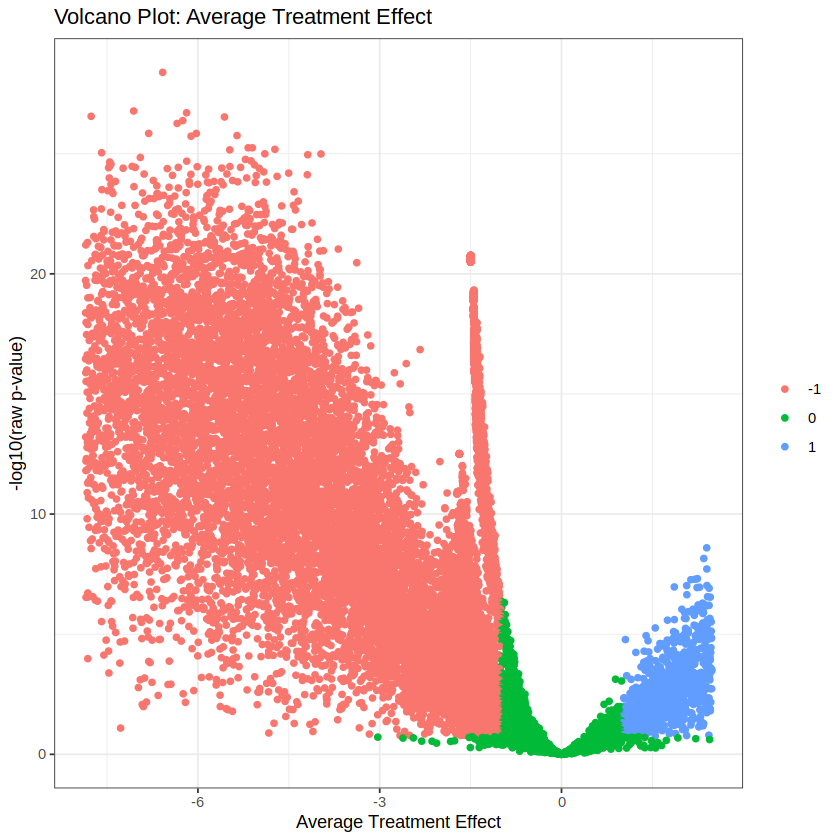

In [ ]:
volcano_ic(biotmle = modtmle_out_cir)

In [ ]:
top_genes_cir <- modtmle_out_cir@topTable %>%
      dplyr::filter(adj.P.Val < 0.01) %>%
      dplyr::arrange(adj.P.Val) %>%
      dplyr::slice(seq_len(50))

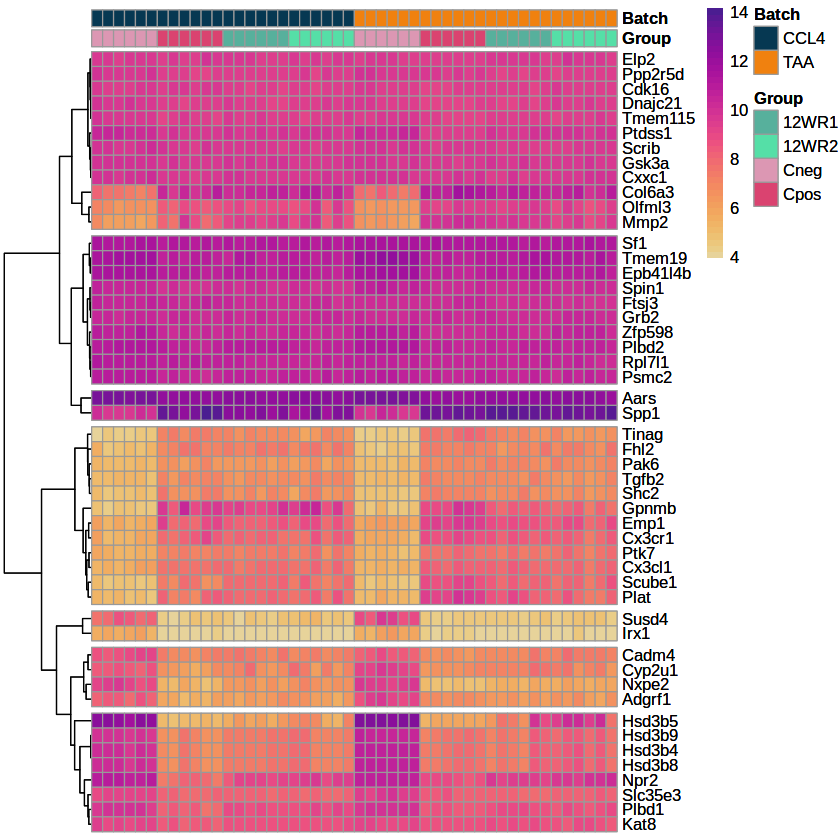

In [ ]:
hm_1 <- produce_heatmap(top_genes_cir, se_cir, dds) 
hm_1

## biotmle - regression

In [ ]:
coldata_reg <- as.data.frame(dds@colData) %>%
  dplyr::select("Batch", "Regression")

In [ ]:
se_reg <- SummarizedExperiment(assays = list(counts = assay(dds)), colData = coldata_reg)

In [ ]:
#colData(dds)
reg_meta <- which(names(colData(se_reg)) %in% "Regression")

In [ ]:
se_reg@colData$Regression[se_reg@colData$Regression == "negative"] <- 0 
se_reg@colData$Regression[se_reg@colData$Regression == "positive"] <- 0 
se_reg@colData$Regression[se_reg@colData$Regression == "regression"] <- 1

se_reg@colData$Batch[se_reg@colData$Batch == "CCL4"] <- 3 
se_reg@colData$Batch[se_reg@colData$Batch == "TAA"] <- 4

In [ ]:
modtmle_out_reg <- biotmle_rnaseq(se_reg, reg_meta)

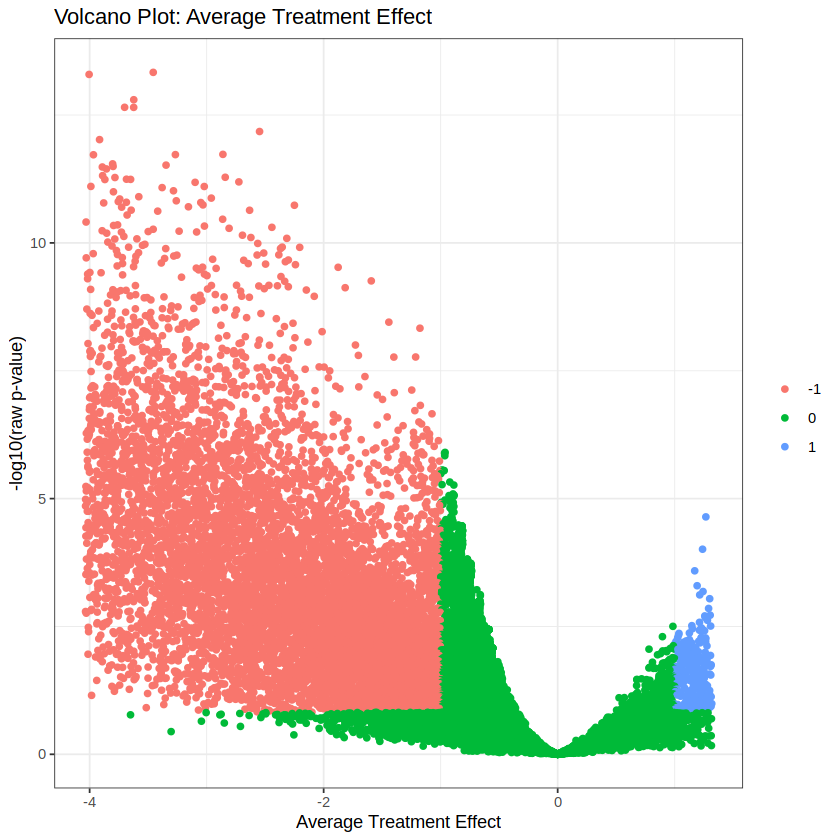

In [ ]:
volcano_ic(biotmle = modtmle_out_reg)

In [ ]:
top_genes_reg <- modtmle_out_reg@topTable %>%
      dplyr::filter(adj.P.Val < 0.01) %>%
      dplyr::arrange(adj.P.Val) %>%
      dplyr::slice(seq_len(50))

In [ ]:
tmp1 = as.numeric(as.character(top_genes_reg$ID))
tmp2 = assay(dds)[tmp1, ]

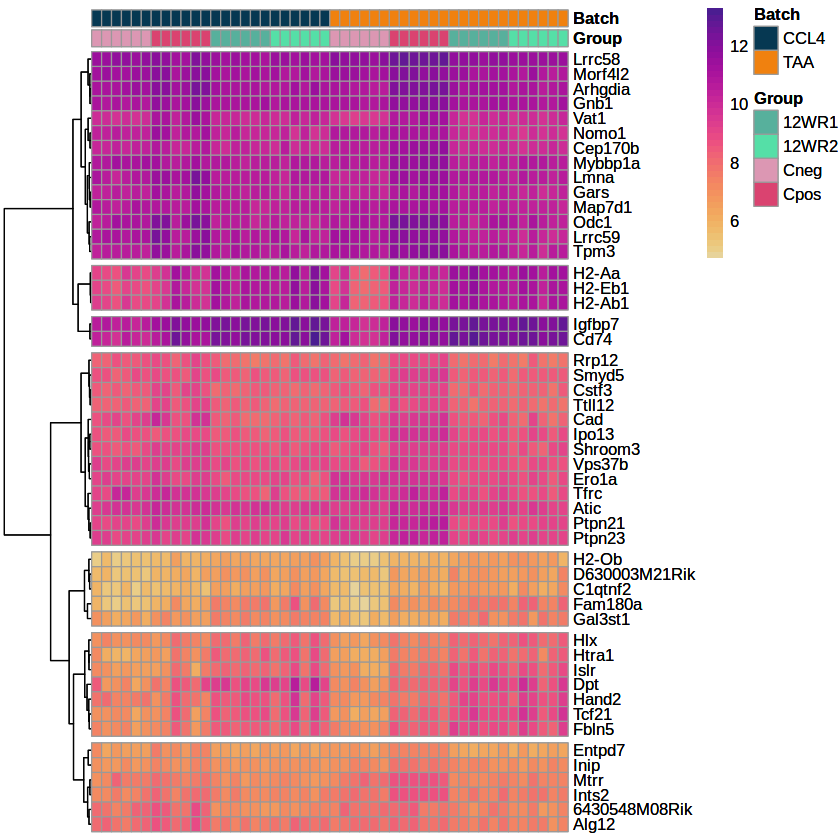

In [ ]:
hm_2 <- produce_heatmap(top_genes_reg, se_reg, dds) 
hm_2

## biotmle - model (CCL4 vs TAA)

In [ ]:
coldata_Batch <- as.data.frame(dds@colData) %>%
  dplyr::select("Batch", "Group")

In [ ]:
se_Batch <- SummarizedExperiment(assays = list(counts = assay(dds)), colData = coldata_Batch)

In [ ]:
#colData(dds)
Batch_meta <- which(names(colData(se_Batch)) %in% "Batch")

In [ ]:
se_Batch@colData$Batch[se_Batch@colData$Batch == "CCL4"] <- 0
se_Batch@colData$Batch[se_Batch@colData$Batch == "TAA"] <- 1

se_Batch@colData$Group[se_Batch@colData$Group == "Cpos"] <- 2 
se_Batch@colData$Group[se_Batch@colData$Group == "Cneg"] <- 3
se_Batch@colData$Group[se_Batch@colData$Group == "R1"] <- 4
se_Batch@colData$Group[se_Batch@colData$Group == "R2"] <- 5

In [ ]:
modtmle_out_Batch <- biotmle_rnaseq(se_Batch, Batch_meta)

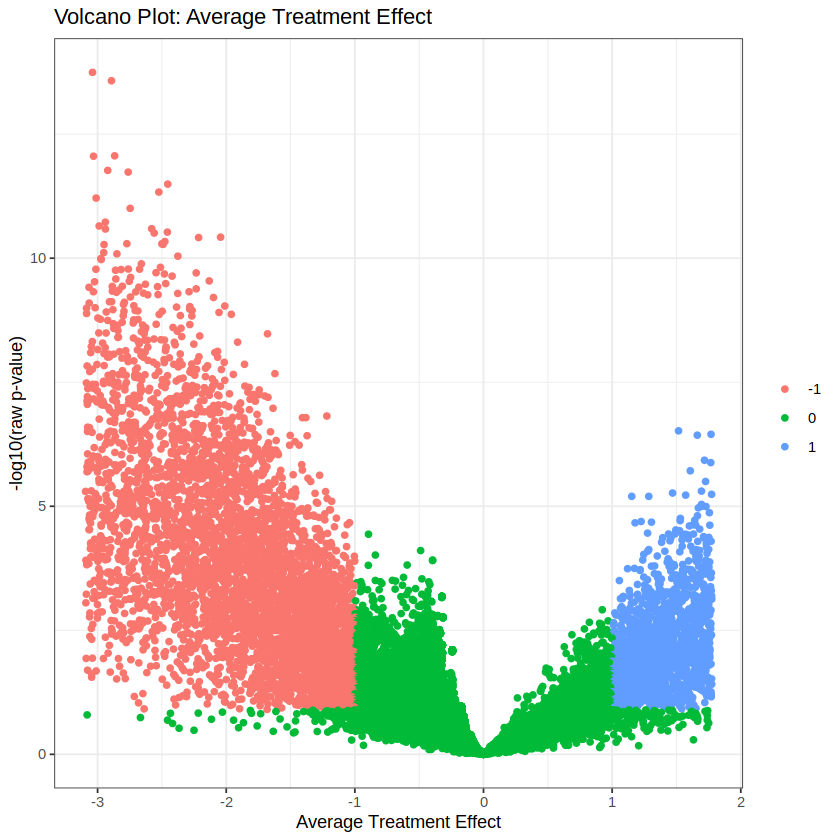

In [ ]:
volcano_ic(biotmle = modtmle_out_Batch)

In [ ]:
top_genes_Batch <- modtmle_out_Batch@topTable %>%
      dplyr::filter(adj.P.Val < 0.01) %>%
      dplyr::arrange(adj.P.Val) %>%
      dplyr::slice(seq_len(50))

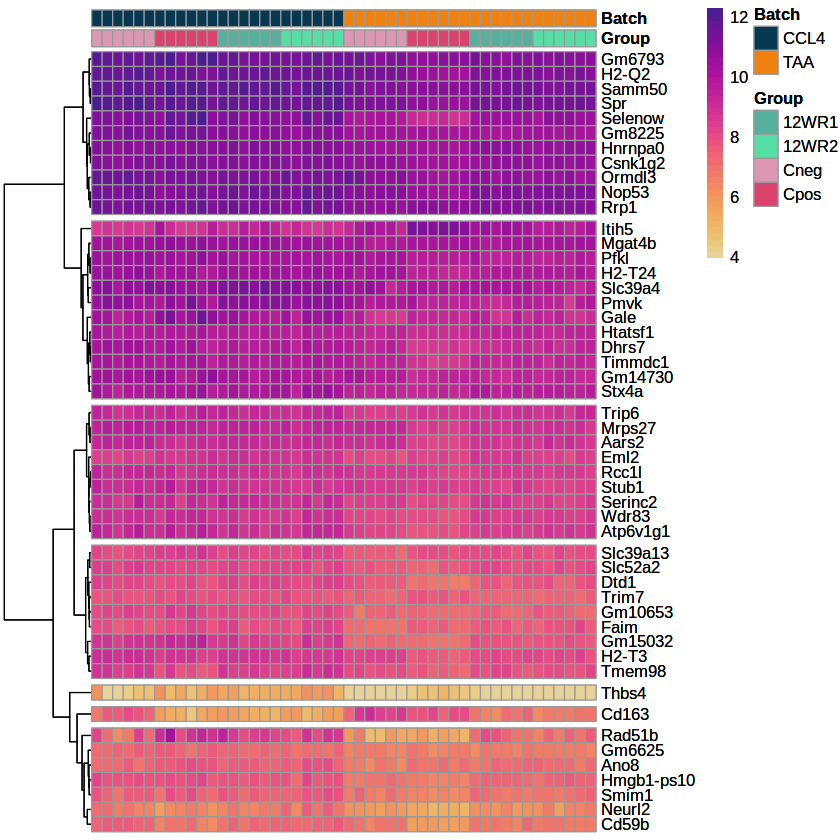

In [ ]:
hm_3 <- produce_heatmap(top_genes_Batch, se_Batch, dds) 
hm_3

## biotmle: PP

In [99]:
coldata_pp <- as.data.frame(dds@colData) %>%
  dplyr::select("PP", "Group")

In [100]:
coldata_pp <- coldata_pp %>%
        mutate(PP_val = 0) %>%
        mutate(PP_val = case_when(PP <= 4.9 ~ '1',
                            TRUE ~ as.character (PP_val))) %>%
        mutate(PP_val = case_when((PP > 5 & PP <= 9.9) ~ '2',
                            TRUE ~ as.character (PP_val))) %>%
        mutate(PP_val = case_when(PP > 10 ~ '3',
                            TRUE ~ as.character (PP_val)))

In [101]:
se_pp <- SummarizedExperiment(assays = list(counts = assay(dds)), colData = coldata_pp)

In [102]:
pp_meta <- which(names(colData(se_pp)) %in% "PP_val")

In [103]:
se_pp@colData$Group[se_pp@colData$Group == "Cpos"] <- 4
se_pp@colData$Group[se_pp@colData$Group == "Cneg"] <- 5
se_pp@colData$Group[se_pp@colData$Group == "R1"] <- 6
se_pp@colData$Group[se_pp@colData$Group == "R2"] <- 7

In [ ]:
modtmle_out_pp <- biotmle_rnaseq(se_pp, pp_meta)

In [ ]:
modtmle_out_pp

class: bioTMLE 
dim: 25867 48 
metadata(0):
assays(1): expMeasures
rownames(25867): Xkr4 Gm19938 ... Erdr1 LOC100861691
rowData names(0):
colnames(48): CDL_0002 CDL_0003 ... CDL_0137 CDL_0138
colData names(3): PP Group PP_val

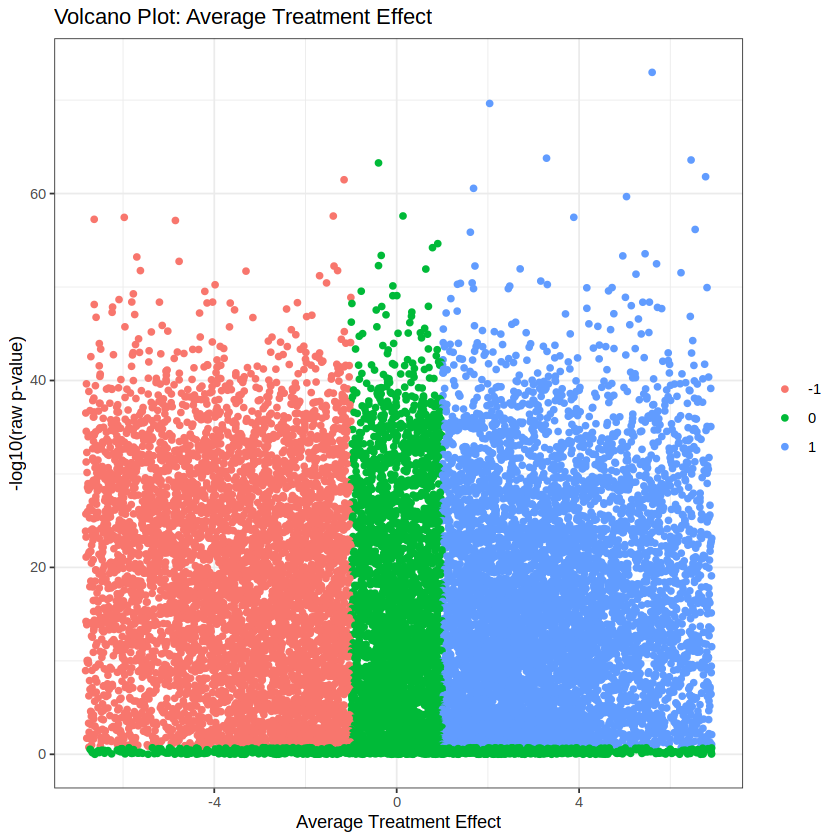

In [ ]:
volcano_ic(biotmle = modtmle_out_pp)

In [ ]:
top_genes_pp <- modtmle_out_pp@topTable %>%
      dplyr::filter(adj.P.Val < 0.01) %>%
      dplyr::arrange(adj.P.Val) %>%
      dplyr::slice(seq_len(50))

In [112]:
produce_heatmap_pp <- function(top_genes, se, dds){
    top_genes_idx = top_genes$ID
    top_genes_idx = as.numeric(as.character(top_genes_idx))
    mtx = assay(se)[top_genes_idx, ]
    annotation = as.data.frame(colData(dds)[, c("Group", "Batch", "PP")])
    annotation = annotation %>%
        mutate(Portal_pressure = 0) %>%
        mutate(Portal_pressure = case_when(PP <= 5.99 ~ '< 6 mmHg',
                            TRUE ~ as.character (Portal_pressure))) %>%
        mutate(Portal_pressure = case_when((PP > 6 & PP <= 9.99) ~ '6..10 mmHg',
                            TRUE ~ as.character (Portal_pressure))) %>%
        mutate(Portal_pressure = case_when(PP > 10 ~ '> 10 mmHg',
                            TRUE ~ as.character (Portal_pressure))) %>%
    dplyr::select(-PP) %>%
    dplyr::relocate(Portal_pressure)
    
    ann_colors <- list(Portal_pressure = c(`< 6 mmHg` = "#cdce9f", `6..10 mmHg` = "#9554b4",  `> 10 mmHg` = "#83d6da"),
                       Group = c(`12WR1` = "#57b09c", `12WR2` = "#55dfa7", Cneg = "#dc97b3", Cpos = "#da4370"), 
                       Batch = c(CCL4 = "#063852", TAA = "#F0810F"))
                       
    pheatmap(scale(mtx), color = c("#D35C79", "#D79D86", "#CCCDC6", "#8AB49B", "#009593"), breaks = c(-3, -1, -0.1, 0.1, 1, 3), cluster_rows = TRUE,
        show_rownames = TRUE, cluster_cols = FALSE,
        annotation_col = annotation,
        show_colnames = FALSE, clustering_method = "ward.D2",
        annotation_colors = ann_colors,
        cutree_rows = 7)
}

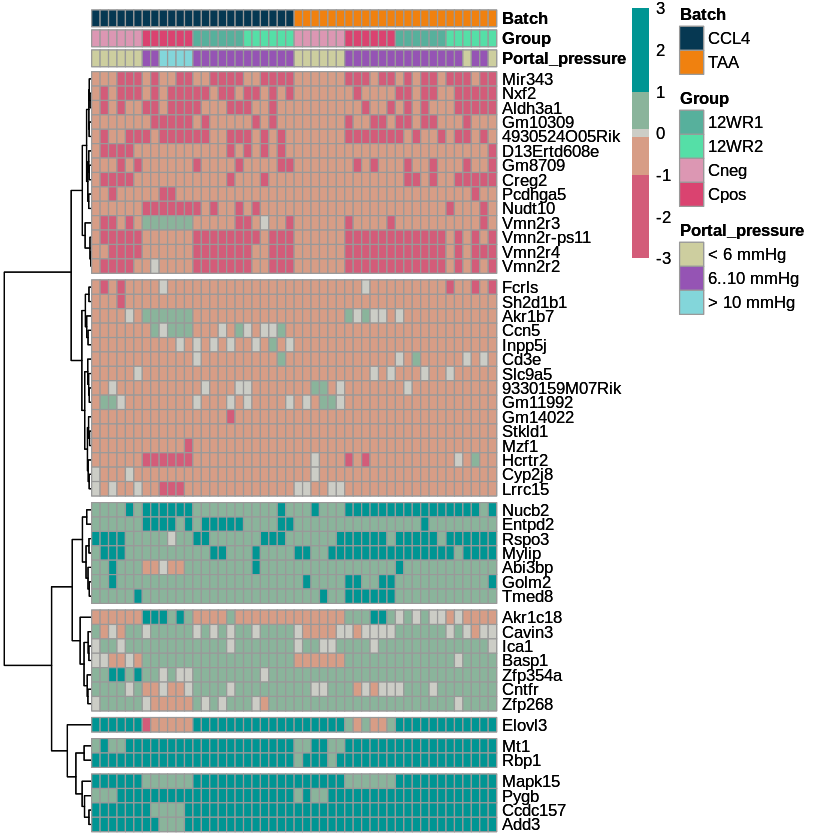

In [115]:
top_genes_1 <- top_genes_pp %>% top_n(50, adj.P.Val)
hm_4 <- produce_heatmap_pp(top_genes_1, se_pp, dds) 
hm_4


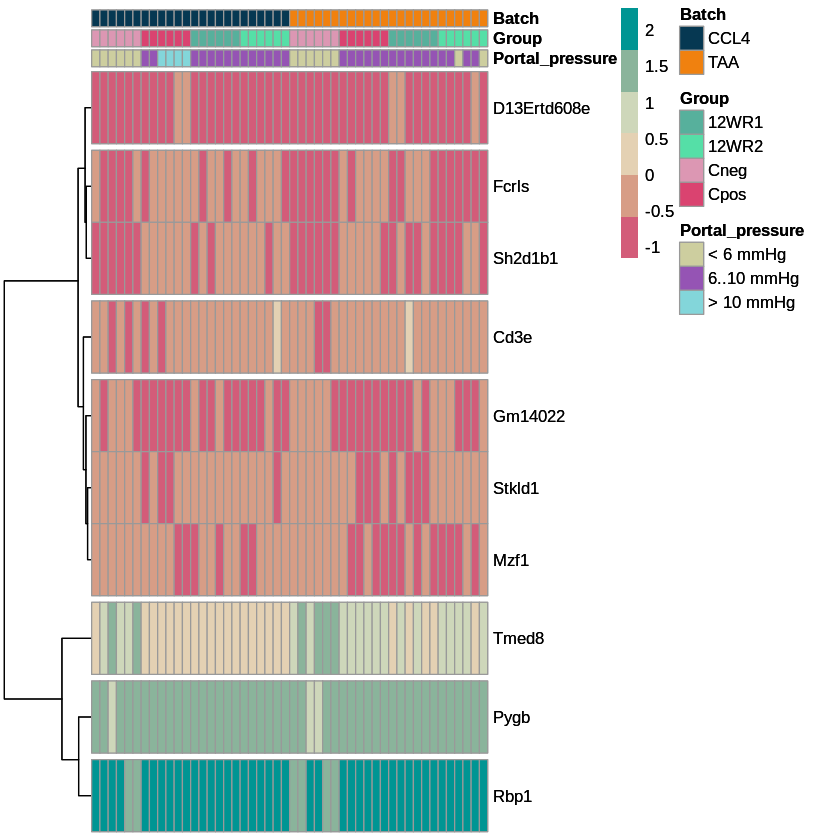

In [110]:
hm_4 <- produce_heatmap_pp(top_genes_pp, se_pp, dds) 
hm_4


## biotmle: CPA

In [118]:
coldata_cpa <- as.data.frame(dds@colData) %>%
  dplyr::select("CPA", "Group")

In [119]:
coldata_cpa <- coldata_cpa %>%
        mutate(CPA_value = 0) %>%
        mutate(CPA_value = case_when(CPA <= 1.99 ~ '1',
                            TRUE ~ as.character (CPA_value))) %>%
        mutate(CPA_value = case_when((CPA > 2 & CPA <= 9.99) ~ '2',
                            TRUE ~ as.character (CPA_value))) %>%
        mutate(CPA_value = case_when(CPA > 10 ~ '3',
                            TRUE ~ as.character (CPA_value)))

In [120]:
se_cpa <- SummarizedExperiment(assays = list(counts = assay(dds)), colData = coldata_cpa)

In [121]:
se_cpa@colData$Group[se_cpa@colData$Group == "Cpos"] <- 4
se_cpa@colData$Group[se_cpa@colData$Group == "Cneg"] <- 5
se_cpa@colData$Group[se_cpa@colData$Group == "R1"] <- 6
se_cpa@colData$Group[se_cpa@colData$Group == "R2"] <- 7

In [122]:
cpa_meta <- which(names(colData(se_cpa)) %in% "CPA_value")

In [ ]:
modtmle_out_cpa <- biotmle_rnaseq(se_cpa, cpa_meta)

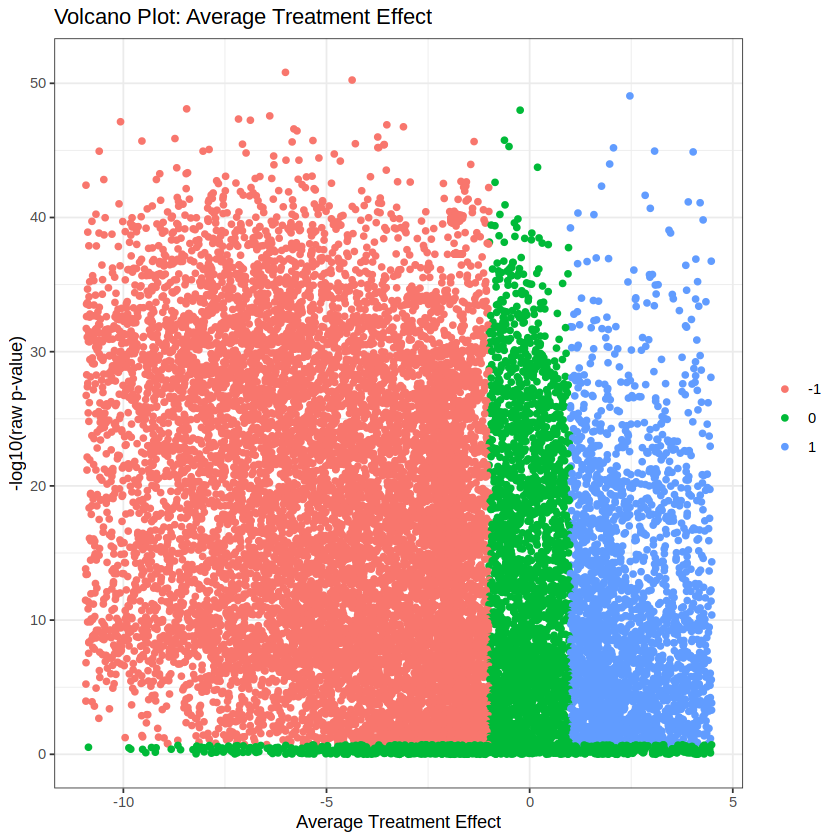

In [ ]:
volcano_ic(biotmle = modtmle_out_cpa)

In [ ]:
top_genes_cpa <- modtmle_out_cpa@topTable %>%
      dplyr::filter(adj.P.Val < 0.01) %>%
      dplyr::arrange(adj.P.Val) %>%
      dplyr::slice(seq_len(50))

In [116]:
produce_heatmap_CPA <- function(top_genes, se, dds){
    top_genes_idx = top_genes$ID
    top_genes_idx = as.numeric(as.character(top_genes_idx))
    mtx = assay(se)[top_genes_idx, ]
    annotation = as.data.frame(colData(dds)[, c("Group", "Batch", "CPA")])
    annotation = annotation %>%
        mutate(CPA_value = 0) %>%
        mutate(CPA_value = case_when(CPA <= 1.99 ~ '< 1.9%',
                            TRUE ~ as.character (CPA_value))) %>%
        mutate(CPA_value = case_when((CPA > 2 & CPA <= 9.99) ~ '2..9%',
                            TRUE ~ as.character (CPA_value))) %>%
        mutate(CPA_value = case_when(CPA > 10 ~ '> 10%',
                            TRUE ~ as.character (CPA_value))) %>%
    dplyr::select(-CPA) %>%
    dplyr::relocate(CPA_value)
    
    ann_colors <- list(CPA_value = c(`< 1.9%` = "#cdce9f", `2..9%` = "#81d5dd",  `> 10%` = "#ebb0a4"),
                       Group = c(`12WR1` = "#57b09c", `12WR2` = "#55dfa7", Cneg = "#dc97b3", Cpos = "#da4370"), 
                       Batch = c(CCL4 = "#063852", TAA = "#F0810F"))
                       
    pheatmap(scale(mtx), color = c("#D35C79", "#D79D86", "#CCCDC6", "#8AB49B", "#009593"), breaks = c(-3, -1, -0.1, 0.1, 1, 3), cluster_rows = TRUE,
        show_rownames = TRUE, cluster_cols = FALSE,
        annotation_col = annotation,
        show_colnames = FALSE, clustering_method = "ward.D2",
        annotation_colors = ann_colors,
        cutree_rows = 7)
}

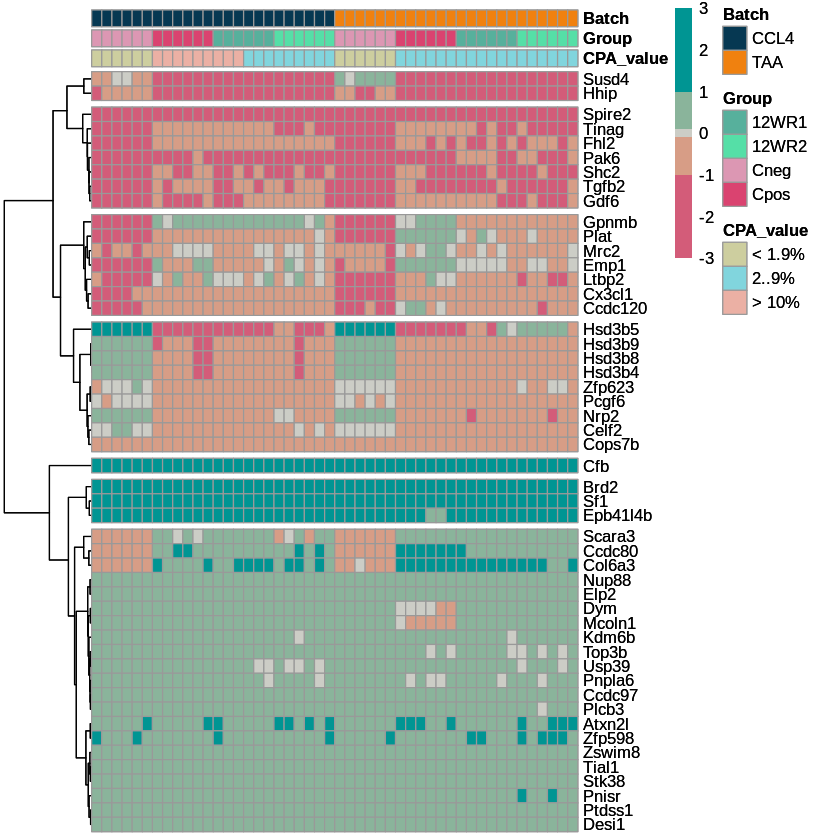

In [123]:
top_genes_4 <- top_genes_cpa %>% top_n(50, adj.P.Val)
hm_5 <- produce_heatmap_CPA(top_genes_4, se_cpa, dds) 
hm_5


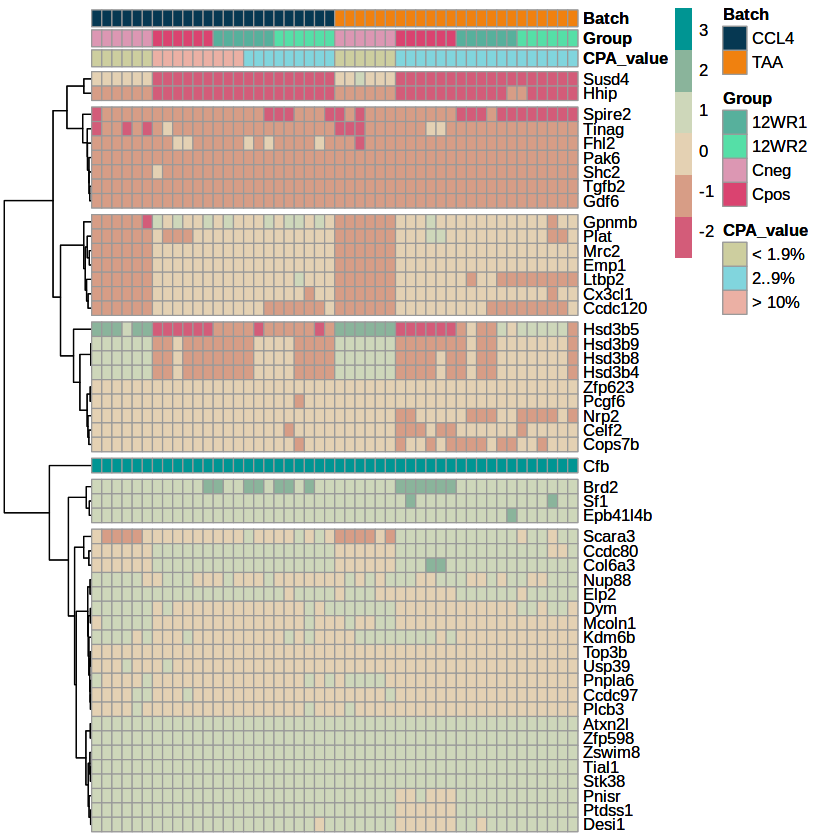

In [ ]:
hm_5 <- produce_heatmap_CPA(top_genes_cpa, se_cpa, dds) 
hm_5

## Top 200 genes

In [3]:
cir <- readRDS("03_outputs/06/modtmle_out_cir.Rds")
pp <- readRDS("03_outputs/06/modtmle_out_pp.Rds")
cpa <- readRDS("03_outputs/06/modtmle_out_cpa.Rds")
reg <- readRDS("03_outputs/06/modtmle_out_reg.Rds")


In [4]:
top_genes_cir <- as.data.frame(cir@topTable) %>%
      dplyr::filter(adj.P.Val < 0.01) %>%
      dplyr::arrange(adj.P.Val) %>%
      dplyr::slice(seq_len(50))

top_genes_pp <- as.data.frame(pp@topTable) %>%
      dplyr::filter(adj.P.Val < 0.01) %>%
      dplyr::arrange(adj.P.Val) %>%
      dplyr::slice(seq_len(50))

top_genes_cpa <- as.data.frame(cpa@topTable) %>%
      dplyr::filter(adj.P.Val < 0.01) %>%
      dplyr::arrange(adj.P.Val) %>%
      dplyr::slice(seq_len(50))

top_genes_reg <- as.data.frame(reg@topTable) %>%
      dplyr::filter(adj.P.Val < 0.01) %>%
      dplyr::arrange(adj.P.Val) %>%
      dplyr::slice(seq_len(50))

In [11]:
se_all <- SummarizedExperiment(assays = list(counts = assay(dds)), colData = colData(dds))

In [18]:
dds_n <- vst(dds)

In [12]:
top_genes_1 <- top_genes_pp %>% top_n(10, adj.P.Val)
top_genes_2 <- top_genes_cir %>% top_n(10, adj.P.Val)
top_genes_3 <- top_genes_reg %>% top_n(10, adj.P.Val)
top_genes_4 <- top_genes_cpa %>% top_n(10, adj.P.Val)

top_genes_all <- rbind(top_genes_2, top_genes_3, top_genes_1, top_genes_4)

In [13]:
top_genes_1 <- top_genes_pp %>% top_n(40, adj.P.Val)

In [22]:
colfunc <- colorRampPalette(c("#9f294c", "#e4f0ff", "#27678a"))
col_100 <- colfunc(10)
col_100 <- col_100[rev(1:length(col_100))]

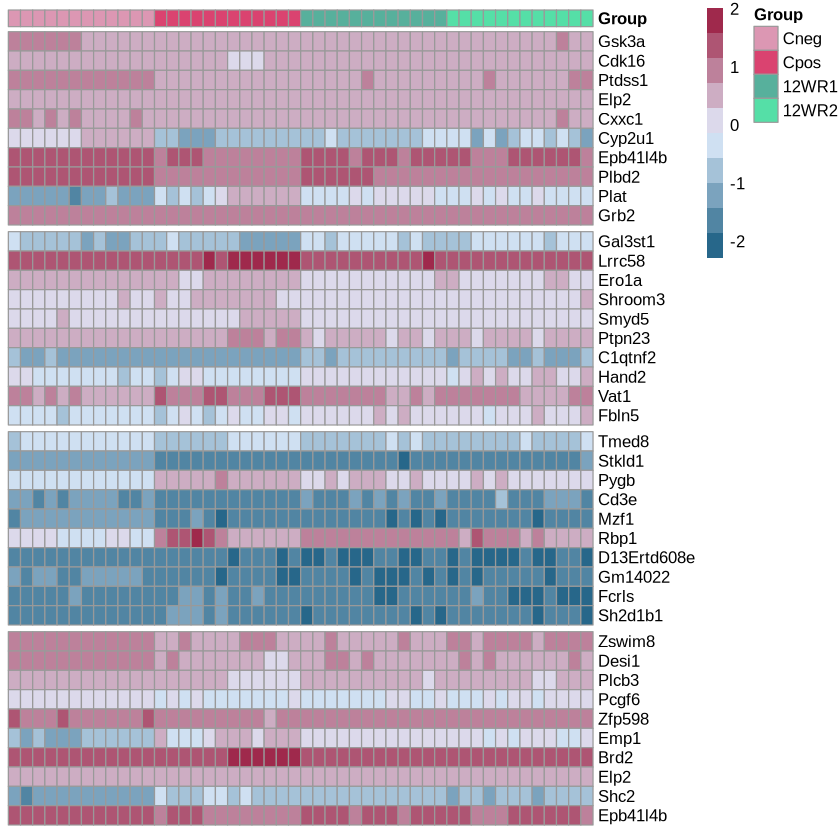

In [23]:
order_merged <- as.data.frame(colData(dds)[, c("Group", "Batch")]) %>% dplyr::select("Group") %>% dplyr::arrange(factor(Group, levels = c("Cneg", "Cpos", "12WR1", "12WR2")))
top_genes_idx <- top_genes_all$ID
top_genes_idx <- as.numeric(as.character(top_genes_idx))
mtx <- assay(dds_n)[top_genes_idx, ]
mtx <- mtx[ , rownames(order_merged)]
#mts <- log2(mtx + 0.001)
annotation <- order_merged
 ann_colors <- list(Group = c(Cneg = "#dc97b3", Cpos = "#da4370", `12WR1` = "#57b09c", `12WR2` = "#55dfa7"))
pheatmap(scale(mtx), color = col_100, cluster_rows = FALSE,
    show_rownames = TRUE, cluster_cols = FALSE, 
       gaps_row = c(10, 20, 30, 40),
    annotation_col = annotation,
    show_colnames = FALSE, clustering_method = "ward.D2",
     annotation_colors = ann_colors,
    cutree_rows = 7)

In [69]:
produce_heatmap_all <- function(top_genes, se, dds){
    top_genes_idx = top_genes$ID
    top_genes_idx = as.numeric(as.character(top_genes_idx))
    mtx = assay(se)[top_genes_idx, ]
    annotation = as.data.frame(colData(dds)[, c("Group", "Batch")]) %>% dplyr::select("Group") %>% dplyr::arrange(factor(Group, levels = c("Cneg", "Cpos", "12WR1", "12WR2")))
   # ann_colors <- c(Cneg = "#dc97b3", Cpos = "#da4370", `12WR1` = "#57b09c", `12WR2` = "#55dfa7")
    pheatmap(scale(mtx), color = hcl.colors(6, "TealRose", rev = FALSE), cluster_rows = FALSE,
        show_rownames = TRUE, cluster_cols = FALSE, 
     #   gaps_row = c(10, 20, 30, 40),
        annotation_col = annotation,
        show_colnames = FALSE, clustering_method = "ward.D2",
       # annotation_colors = ann_colors,
        cutree_rows = 7)
}

In [43]:
as_t <- colData(dds)
as_t$Group

[1] "Cneg"  "Cneg"  "Cneg"  "Cneg"  "Cneg"  "Cneg"  "Cpos"  "Cpos"  "Cpos" 
[10] "Cpos"  "Cpos"  "Cpos"  "12WR1" "12WR1" "12WR1" "12WR1" "12WR1" "12WR1"
[19] "12WR2" "12WR2" "12WR2" "12WR2" "12WR2" "12WR2" "Cneg"  "Cneg"  "Cneg" 
[28] "Cneg"  "Cneg"  "Cneg"  "Cpos"  "Cpos"  "Cpos"  "Cpos"  "Cpos"  "Cpos" 
[37] "12WR1" "12WR1" "12WR1" "12WR1" "12WR1" "12WR1" "12WR2" "12WR2" "12WR2"
[46] "12WR2" "12WR2" "12WR2"

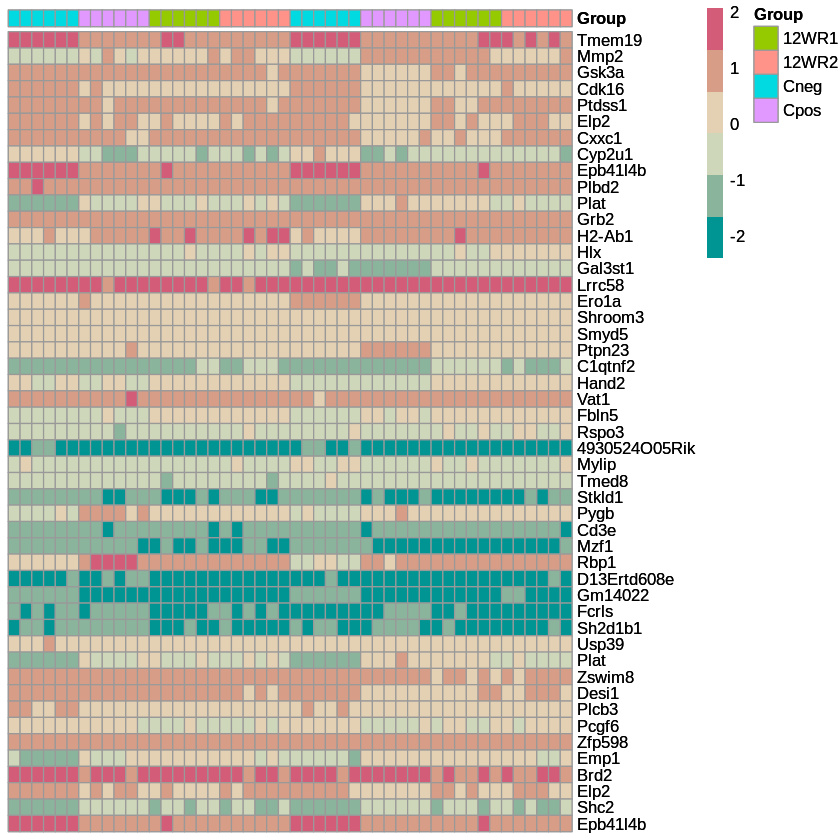

In [70]:
hm_1 <- produce_heatmap_all(top_genes_all, se_all, dds) 
hm_1

In [66]:
top_genes_idx <- as.numeric(as.character(top_genes_cir$ID))
top200_cir <- rownames(assay(se_cir)[top_genes_idx, ])

top_genes_idx <- as.numeric(as.character(top_genes_pp$ID))
top200_pp <- rownames(assay(se_cir)[top_genes_idx, ])

top_genes_idx <- as.numeric(as.character(top_genes_cpa$ID))
top200_cpa <- rownames(assay(se_cir)[top_genes_idx, ])

top_genes_idx <- as.numeric(as.character(top_genes_reg$ID))
top200_reg <- rownames(assay(se_cir)[top_genes_idx, ])

In [70]:
top200_genes_tmle <- data.frame(cir = top200_cir, pp = top200_pp, cpa = top200_cpa, reg = top200_reg)

## Outputs

In [10]:
write.csv(top_genes_cir, "03_outputs/06/biotmle_top_genes_cir_sig.csv")
write.csv(top_genes_reg, "03_outputs/06/biotmle_top_genes_reg_sig.csv")
write.csv(top_genes_Batch, "03_outputs/06/biotmle_top_genes_Batch_sig.csv")
write.csv(top_genes_pp, "03_outputs/06/biotmle_top_genes_pp_sig.csv")
write.csv(top_genes_cpa, "03_outputs/06/biotmle_top_genes_cpa_sig.csv")

In [80]:
write.csv(top200_genes_tmle, "03_outputs/06/top200_genes_tmle.csv")

In [85]:
ggsave("03_outputs/06/biotmle_hm_cir.png", hm_1, device = "png")
ggsave("03_outputs/06/biotmle_hm_reg.png", hm_2, device = "png")
ggsave("03_outputs/06/biotmle_hm_Batch.png", hm_3, device = "png")
ggsave("03_outputs/06/biotmle_hm_pp.png", hm_4, device = "png")
#ggsave("03_outputs/06/biotmle_hm_cpa.png", hm_5, device = "png")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [92]:
saveRDS(modtmle_out_cir, "03_outputs/06/modtmle_out_cir.Rds")
saveRDS(modtmle_out_reg, "03_outputs/06/modtmle_out_reg.Rds")
saveRDS(modtmle_out_Batch, "03_outputs/06/modtmle_out_Batch.Rds")
saveRDS(modtmle_out_pp, "03_outputs/06/modtmle_out_pp.Rds")
saveRDS(modtmle_out_cpa, "03_outputs/06/modtmle_out_cpa.Rds")

In [7]:
modtmle_out_cir <- readRDS("03_outputs/06/modtmle_out_cir.Rds")
modtmle_out_reg <- readRDS("03_outputs/06/modtmle_out_reg.Rds")
modtmle_out_Batch <- readRDS("03_outputs/06/modtmle_out_Batch.Rds")
modtmle_out_pp <- readRDS("03_outputs/06/modtmle_out_pp.Rds")
modtmle_out_cpa <- readRDS("03_outputs/06/modtmle_out_cpa.Rds")

In [9]:
top_genes_cir <- modtmle_out_cir@topTable %>%
      dplyr::filter(adj.P.Val < 0.01) %>%
      dplyr::arrange(adj.P.Val)

top_genes_reg <- modtmle_out_reg@topTable %>%
      dplyr::filter(adj.P.Val < 0.01) %>%
      dplyr::arrange(adj.P.Val)

top_genes_Batch <- modtmle_out_Batch@topTable %>%
      dplyr::filter(adj.P.Val < 0.01) %>%
      dplyr::arrange(adj.P.Val)

top_genes_pp <- modtmle_out_pp@topTable %>%
      dplyr::filter(adj.P.Val < 0.01) %>%
      dplyr::arrange(adj.P.Val)

top_genes_cpa <- modtmle_out_cpa@topTable %>%
      dplyr::filter(adj.P.Val < 0.01) %>%
      dplyr::arrange(adj.P.Val)

In [ ]:
top_genes_cpa <- tmp@topTable %>%
      dplyr::filter(adj.P.Val < 0.05) %>%
      dplyr::arrange(adj.P.Val) %>%
      dplyr::slice(seq_len(50))